<a href="https://colab.research.google.com/github/sameerchahande-lab/Sameer-/blob/main/LIBRARYS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
```yaml
name: Upload videos to YouTube

on:
  push:
    paths:
      - 'videos/**'

jobs:
  upload:
    runs-on: ubuntu-latest
    concurrency:
      group: upload-to-youtube
      cancel-in-progress: true
    steps:
      - name: Checkout repository
        uses: actions/checkout@v4

      - name: Setup Node.js
        uses: actions/setup-node@v4
        with:
          node-version: '20'

      - name: Install dependencies
        run: |
          npm ci

      - name: Run YouTube upload for changed video files
        env:
          GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
          YT_CLIENT_ID: ${{ secrets.YT_CLIENT_ID }}
          YT_CLIENT_SECRET: ${{ secrets.YT_CLIENT_SECRET }}
          YT_REFRESH_TOKEN: ${{ secrets.YT_REFRESH_TOKEN }}
          DEFAULT_PRIVACY: ${{ secrets.YT_DEFAULT_PRIVACY }} # public|unlisted|private (optional)
          DEFAULT_CATEGORY_ID: ${{ secrets.YT_DEFAULT_CATEGORY_ID }} # numeric category id (optional)
        run: |
          node ./scripts/ci-upload.js "${GITHUB_EVENT_PATH}"

SyntaxError: invalid syntax (ipython-input-3418477712.py, line 1)

In [ ]:
name: Upload videos to YouTube

on:
  push:
    paths:
      - 'videos/**'
  workflow_dispatch:

jobs:
  upload:
    runs-on: ubuntu-latest
    concurrency:
      group: upload-to-youtube
      cancel-in-progress: true
    steps:
      - name: Checkout repository
        uses: actions/checkout@v4

      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: '3.11'

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt

      - name: Run YouTube upload for changed video files
        env:
          GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
          YT_CLIENT_ID: ${{ secrets.YT_CLIENT_ID }}
          YT_CLIENT_SECRET: ${{ secrets.YT_CLIENT_SECRET }}
          YT_REFRESH_TOKEN: ${{ secrets.YT_REFRESH_TOKEN }}
          DEFAULT_PRIVACY: ${{ secrets.YT_DEFAULT_PRIVACY }} # public|unlisted|private (optional)
          DEFAULT_CATEGORY_ID: ${{ secrets.YT_DEFAULT_CATEGORY_ID }} # numeric category id (optional)
        run: |
          python scripts/ci_upload.py "${GITHUB_EVENT_PATH}"

SyntaxError: invalid syntax (ipython-input-3216941670.py, line 1)

In [ ]:
#!/usr/bin/env python3
"""
ci_upload.py

- Reads the GitHub event JSON (path passed as first arg or from GITHUB_EVENT_PATH)
- Collects files added/modified across commits
- Filters for videos/ and common video extensions
- Uploads each file to YouTube using OAuth2 refresh token and google-api-python-client

Required env:
 - YT_CLIENT_ID
 - YT_CLIENT_SECRET
 - YT_REFRESH_TOKEN
 - DEFAULT_PRIVACY (optional, default 'unlisted')
 - DEFAULT_CATEGORY_ID (optional)

Usage:
  python scripts/ci_upload.py "$GITHUB_EVENT_PATH"
"""

import os
import sys
import json
import mimetypes
from pathlib import Path
from typing import List, Set

from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.errors import HttpError

VIDEO_EXTS = {'.mp4', '.mov', '.m4v', '.mkv', '.webm', '.avi', '.flv', '.wmv'}


def collect_changed_files(event_path: str) -> List[str]:
    files: Set[str] = set()

    if event_path and os.path.exists(event_path):
        try:
            with open(event_path, 'r', encoding='utf-8') as f:
                event = json.load(f)
        except Exception as e:
            print(f"Warning: failed to read event file {event_path}: {e}")
            event = {}
        commits = event.get('commits', [])
        for c in commits:
            for f in c.get('added', []) + c.get('modified', []):
                files.add(f)
    else:
        print("GITHUB_EVENT_PATH not provided or doesn't exist; will scan videos/ directory as fallback.")

    # fallback: scan videos/ if nothing found
    if not files:
        videos_dir = Path('videos')
        if videos_dir.exists() and videos_dir.is_dir():
            for p in videos_dir.rglob('*'):
                if p.is_file() and p.suffix.lower() in VIDEO_EXTS:
                    files.add(str(p.as_posix()))

    # filter only video files under videos/
    results = [f for f in files if f.startswith('videos/') and Path(f).suffix.lower() in VIDEO_EXTS]
    return results


def build_credentials(client_id: str, client_secret: str, refresh_token: str) -> Credentials:
    if not (client_id and client_secret and refresh_token):
        raise ValueError("Missing YT_CLIENT_ID, YT_CLIENT_SECRET, or YT_REFRESH_TOKEN environment variables.")

    creds = Credentials(
        token=None,
        refresh_token=refresh_token,
        token_uri='https://oauth2.googleapis.com/token',
        client_id=client_id,
        client_secret=client_secret,
        scopes=['https://www.googleapis.com/auth/youtube.upload', 'https://www.googleapis.com/auth/youtube']
    )
    # Refresh to obtain access token
    creds.refresh(Request())
    return creds


def upload_video(local_path: str, youtube, title: str, description: str, privacy: str = 'unlisted', category_id: str = None, tags: List[str] = None):
    mimetype, _ = mimetypes.guess_type(local_path)
    if not mimetype:
        mimetype = 'video/*'

    body = {
        'snippet': {
            'title': title,
            'description': description,
        },
        'status': {
            'privacyStatus': privacy
        }
    }
    if category_id:
        body['snippet']['categoryId'] = str(category_id)
    if tags:
        body['snippet']['tags'] = tags

    media = MediaFileUpload(local_path, mimetype=mimetype, chunksize=-1, resumable=True)

    try:
        request = youtube.videos().insert(
            part=','.join(body.keys()) + ',snippet' if 'snippet' not in body else 'snippet,status',
            body=body,
            media_body=media
        )
        print(f"Starting upload: {local_path} (title='{title}', privacy='{privacy}')")
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f"Upload progress: {int(status.progress() * 100)}%")
        print(f"Upload finished for {local_path}. YouTube id: {response.get('id')}")
        return response
    except HttpError as e:
        print(f"Upload failed for {local_path}: {e}")
        raise


def main():
    event_path = sys.argv[1] if len(sys.argv) > 1 else os.environ.get('GITHUB_EVENT_PATH')
    files = collect_changed_files(event_path)

    if not files:
        print("No video files to upload.")
        return

    client_id = os.environ.get('YT_CLIENT_ID')
    client_secret = os.environ.get('YT_CLIENT_SECRET')
    refresh_token = os.environ.get('YT_REFRESH_TOKEN')
    default_privacy = os.environ.get('DEFAULT_PRIVACY', 'unlisted')
    default_category_id = os.environ.get('DEFAULT_CATEGORY_ID')

    try:
        creds = build_credentials(client_id, client_secret, refresh_token)
    except Exception as e:
        print(f"Authentication failure: {e}")
        sys.exit(1)

    youtube = build('youtube', 'v3', credentials=creds, cache_discovery=False)

    for f in files:
        local_path = Path(f)
        if not local_path.exists():
            print(f"Warning: {local_path} doesn't exist on runner, skipping.")
            continue

        title = local_path.stem
        description = f"Uploaded from repo (automated). File: {f}"
        try:
            upload_video(str(local_path), youtube, title, description, privacy=default_privacy, category_id=default_category_id)
        except Exception as e:
            print(f"Error uploading {f}: {e}")
            # continue to next file

if __name__ == '__main__':
    main()

GITHUB_EVENT_PATH not provided or doesn't exist; will scan videos/ directory as fallback.
No video files to upload.


In [ ]:
a=10
b=30
print(a+b)

40


In [ ]:
a**b

1000000000000000000000000000000

In [ ]:
2**3

8

In [ ]:
#floor division


In [ ]:
60/2

30.0

In [ ]:
60//2

30

In [ ]:
60%5

0

In [ ]:
60%4

0

In [ ]:
30%4

2

In [ ]:
#Assignment Oprators

In [ ]:
var=10
var+=30
print(var)

40


In [ ]:
#Comparison op


In [ ]:
#>,<,>=,<=,!=,==

In [ ]:
a<50

True

In [ ]:
a>50

False

In [ ]:
a!=10

False

In [ ]:
a

10

In [ ]:
#Logical Op

In [ ]:
a==10

True

In [ ]:
b>=10

True

In [ ]:
x=20
y=40

x%2==0 and y==50

False

In [ ]:
x%2==0 or y==50

True

In [ ]:
not (x%2==0 and y==50)

True

In [ ]:
#BITWISE OP

In [ ]:
# and (&),or(|),not(~)

In [ ]:
#Membership Op

In [ ]:
list_1=[10,20,30,40,50,60]
40 in list_1

True

In [ ]:
90 in list_1

False

In [ ]:
tuple_1=(10,23,25,42)
50 not in tuple_1

True

In [ ]:
10 in tuple_1

True

In [ ]:
40 in tuple_1

False

In [ ]:
23 in tuple_1

True

In [ ]:
#Identity op

In [ ]:
a=90
b=30
id(a)

11657224

In [ ]:
id(b)

11655304

In [ ]:
a is b

False

In [ ]:
x=90

In [ ]:
id(x)

11657224

In [ ]:
a is x

True

In [ ]:
y=30

In [ ]:
b is y

True

Conditional statement


In [ ]:
#indentation is the 4 space or 1 tab gap in the python which by defaults
get picked up from the new line wheneever we end any previous python statement from colon.


In [ ]:
if condition:
  block of code
  ...........

else:
  block of code
  .....


#if the number is divisible by 2 or not




In [ ]:
num_1=4
if num_1%2==0:
  print("Yes it is divisible by 2")
else:
        print("Not divisible by 2")

Yes it is divisible by 2


In [ ]:
if num_1==5:
  print("Yes it is equal")
else:
    print("Not Equal")

Not Equal


In [ ]:
#if elif else:

In [ ]:
if num_1>5:
  print("yes it is going")
elif num_1==4:
  print("Yes it is match")
else:
  print("Nothing is matching")

Yes it is match


# Control Flow Statements

## Loops

In [ ]:
list_2=[10,20,30,40,50,60,70]

In [ ]:
for temp_var in iterable:
  body to the for loop

In [ ]:
list_2=[10,20,30,40,50,60,70]
for i in list_2:
  print(i)

10
20
30
40
50
60
70


In [ ]:
set_1={10,20,10,40,10,50}
for i in set_1:
  print(i)

40
10
20
50


In [ ]:
dict_1={"name":"Sameer","Age":22,"Speciality":"Stong in buiding models"}
for i in dict_1:
  print(i)

name
Age
Speciality


In [ ]:
for j in dict_1.values():
  print(j)

Sameer
22
Stong in buiding models


In [ ]:
for k in dict_1.items():
  print(k)

('name', 'Sameer')
('Age', 22)
('Speciality', 'Stong in buiding models')


#Build-in function:

1. range()
2. enumerate()
3. zip()

In [ ]:
#to find out even numner from first 10 natural numbers.

for i in range(1,99):
  print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [ ]:
for i in range(2,21,2):
  print(i)

2
4
6
8
10
12
14
16
18
20


In [ ]:
for i in range(2,21,3):
  print(i)

2
5
8
11
14
17
20


In [ ]:
list_1=[55,66,99,88,77,55,66,33]
for i in enumerate(list_1):
  print(i)


(0, 55)
(1, 66)
(2, 99)
(3, 88)
(4, 77)
(5, 55)
(6, 66)
(7, 33)


In [ ]:
list_2=[66,55,88,99,77,78]
list_1=[10,20,30,4,5,60]


for i,j in zip(list_1,list_2):
  print(i+j)

76
75
118
103
82
138


#while loop:

In [ ]:
syntax:
while condition:
  body to your while loop
  write one statement make the condition of while loop false

In [ ]:
x=1

while x<=10:
  print(x)
  x+=1

1
2
3
4
5
6
7
8
9
10


#print all the numbers entered untill user enter the number 0.

In [ ]:
num=int(input("Enter the number"))

while num!=0:
  print(num)
  num=int(input("Enter the next number:"))

print("End")

Enter the number100
100
Enter the next number:69
69
Enter the next number:67
67
Enter the next number:56
56
Enter the next number:0
End


Control statement

In [ ]:
#pass, break and continue

#pass is the null statement that helps us to avoid errors along with it reserve with that it reserve spaces

In [ ]:
for i in range(1,11):
  pass

In [ ]:
#break:is use to terminate the flow of the loop

for i in range(1,11):
  if i==5:
    break

print(i)

5


In [ ]:
for i in range(1,50):
  if i==6 :
    break

print(i)

6


#continue

In [ ]:
for i in range(1,11):
  if i==5 or i==7:
    continue

print(i)

10


In [ ]:
syntax:
def function_name(parameters_1,parameters_2,....):
  body of the function
  print()/return

  #calling the function

  function_name(arg_1,arg_2,...)

In [ ]:
#sum of two numbers using function:

def sum_1(num_1,num_2):
  return(num_1+num_2)

sum_1(10,20)

30

In [ ]:
def sub_1(a,b):
  return(a-b)

In [ ]:
def master(a1,b1):
  ans_1=sum_1(a1,b1)
  ans_2=sub_1(a1,b1)
  return(ans_1,ans_2)

In [ ]:
master(45,89)

(134, -44)

#veriable length argument.

In [ ]:
def sum_n(*param_1):
  sum_1 = 0
  for i in param_1:
    sum_1+=i
  print(sum_1)

In [ ]:
sum_n(10,20,30)

60


In [ ]:
sum_n(60,90,80,60,20)

310


Anonymus Function

In [ ]:
var=lambda arguments_1,arg_2.....:expression
var(10,20)

#cube of a number

In [ ]:
num_cube=lambda a:a**3
num_cube(10)

1000

In [ ]:
num_cube(6)

216

In [ ]:
num_cube(9)

729

check if the given number is even or odd:

In [ ]:
var_1=lambda x:"It is even number" if x%2==0 else "not an even number"
var_1(66)

'It is even number'

In [ ]:
var_1(9)

'not an even number'

Recursive function

In [ ]:
#Recursive function are the function that call themselves in the definition on it

In [ ]:
def name_of_function(*args):
  # body of the function
  pass
  # recursive call example:
  # name_of_function(arg,...)
# call:
# name_of_functions(arg,...)

In [ ]:
def factorial(x):
  if x==1:
    return 1
  else:
    return x * factorial(x-1)

In [ ]:
factorial(3)

6

**Exception**

In [ ]:
try:
  x=int(input("Enter the number"))
  y=int(input("Enter the number"))
  print(x/y)
except ZeroDivisionError:
   print("You are dividing by zero.")
except ValueError:
   print("Please enter a valid number.")
except:
   print("An unexpected error occurred.")
finally:
  print("I am always going to run")

Enter the number36
Enter the number0
You are dividing by zero.
I am always going to run


In [ ]:
0/5

0.0

In [ ]:
try:
  x=int(input("Enter the number:"))
  y=int(input("Enter the number:"))
  print(x/y)
except ZeroDivisionError:
   print("You are dividing by zero.")
except ValueError:
   print("Please enter a valid number.")
except:
   print("An unexpected error occurred.")
finally:
  print("I am always going to run")

Enter the number:56
Enter the number:lk
Please enter a valid number.
I am always going to run


In [ ]:
try:
  x=int(input("Enter the number:"))
  y=int(input("Enter the number:"))
  print(x/y)
except ZeroDivisionError:
   print("You are dividing by zero.")
except ValueError:
   print("Please enter a valid number.")
except:
   print("An unexpected error occurred.")
finally:
  print("I am always going to run")

Enter the number:56
Enter the number:0
You are dividing by zero.
I am always going to run


#LIBRARIES

In [ ]:
#numpy-----> Numerical Python


#--->Array---> An array is the ordered data structure that contain data of similar type.



In [ ]:
import numpy as np

In [ ]:
array_1=np.array([1,2,3])
print(array_1)

[1 2 3]


In [ ]:
array_2=np.array((30,60,50))
print(array_2)

[30 60 50]


In [ ]:
ARRAY_3=np.array([[1,2,3],[4,5,6]])
print(ARRAY_3)

[[1 2 3]
 [4 5 6]]


In [ ]:
np.array([1,2,3],dtype="complex")

array([1.+0.j, 2.+0.j, 3.+0.j])

In [ ]:
np.array([1,2,3],dtype="float")

array([1., 2., 3.])

In [ ]:
list_1=[10,20,30,40]
print(list_1)

[10, 20, 30, 40]


WHAT IS THE MAJOR DIFFERENCE BETWEEN NUMPY ARRAY AND THE PYTHON LISTS:

In [ ]:
array_1

array([1, 2, 3])

In [ ]:
array_2

array([30, 60, 50])

In [ ]:
print(array_1+array_2)

[31 62 53]


In [ ]:
list_1=[2,3,4]
list_2=[50,60,70]
print(list_1+list_2)

[2, 3, 4, 50, 60, 70]


In [ ]:
list_ans = []
for i,j in zip(list_1,list_2):
  list_ans.append(i+j)
  print(list_ans)

[52]
[52, 63]
[52, 63, 74]


#how to check the dimention of the array

In [ ]:
array_1.ndim

1

In [ ]:
ARRAY_3.ndim

2

#how we can check the shape of the metrix (its check rows and colum)

In [ ]:
array_1.shape

(3,)

In [ ]:
ARRAY_3.shape

(2, 3)

#how can we check the size of the array:

In [ ]:
ARRAY_3.size

6

In [ ]:
array_1.size

3

ARRAY ATRIBUTES

In [ ]:
a1=np.arange(10)
print(a1)

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
a2=np.arange(12,dtype="float")
print(a2)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


convert 1D to 2D

In [ ]:
a2=np.arange(12,dtype="float").reshape(3,4)
print(a2)

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]]


In [ ]:
a1=np.arange(10).reshape(5,2)
print(a1)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]


In [ ]:
a2.astype(np.int64)   #changing the data type of array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
a2*4

array([[ 0.,  4.,  8., 12.],
       [16., 20., 24., 28.],
       [32., 36., 40., 44.]])

In [ ]:
a1*8

array([[ 0,  8],
       [16, 24],
       [32, 40],
       [48, 56],
       [64, 72]])

In [ ]:
for i in a2:
  print(i)

[0. 1. 2. 3.]
[4. 5. 6. 7.]
[ 8.  9. 10. 11.]


In [ ]:
for i in np.nditer(a2):
  print(i)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0


In [ ]:
a2>5

array([[False, False, False, False],
       [False, False,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
a2<5

array([[ True,  True,  True,  True],
       [ True, False, False, False],
       [False, False, False, False]])

In [ ]:
a1>5

array([[False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

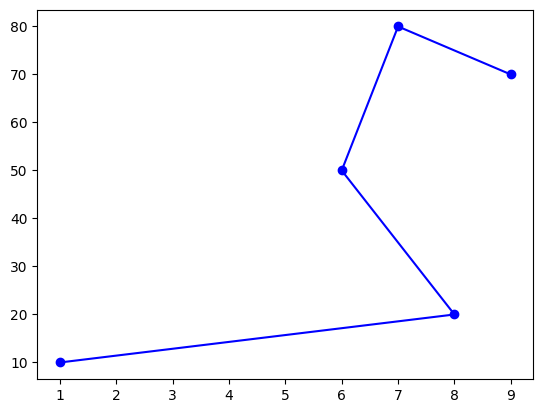

In [ ]:
x=[1,8,6,7,9]
y=[10,20,50,80,70]
plt.plot(x,y,marker="o",color="b")

Text(0.5, 1.0, 'sales portfolio')

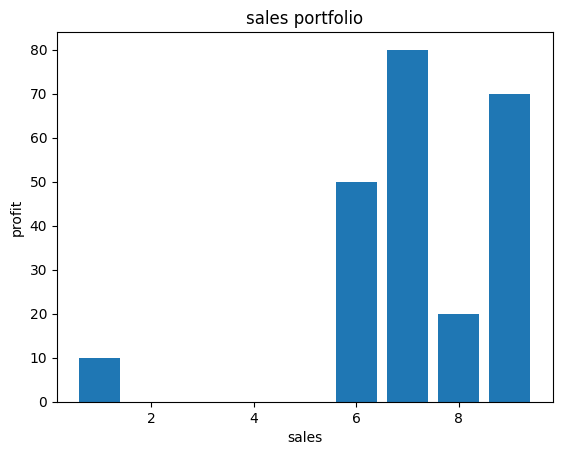

In [ ]:
x_1=[1,8,6,7,9]
y_1=[10,20,50,80,70]
plt.bar(x_1,y_1)

plt.xlabel("sales")
plt.ylabel("profit")

plt.title("sales portfolio")

In [ ]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x: 'float | ArrayLike', height: 'float | ArrayLike', width: 'float | ArrayLike' = 0.8, bottom: 'float | ArrayLike | None' = None, *, align: "Literal['center', 'edge']" = 'center', data=None, **kwargs) -> 'BarContainer'
    Make a bar plot.

    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *height* and *width*. The vertical baseline
    is *bottom* (default 0).

    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.

    Parameters
    ----------
    x : float or array-like
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.

    height : float or array-like
        The height(s) of the bars.

        Note that if *bottom* has units (e.g. datetime), *height* should be in
        units that are a difference from the value of *bottom* (e.g. timedelta).

    width

(array([1., 1., 0., 0., 0., 1., 0., 0., 1., 1.]),
 array([10., 17., 24., 31., 38., 45., 52., 59., 66., 73., 80.]),
 <BarContainer object of 10 artists>)

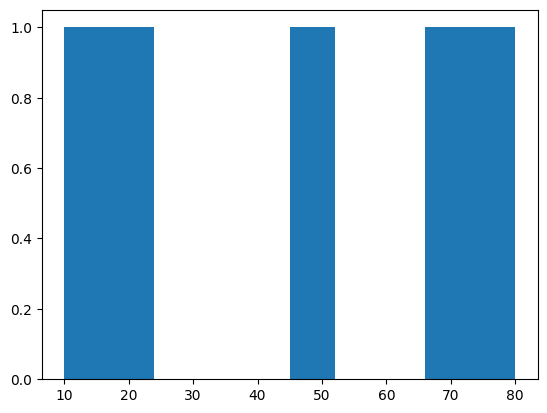

In [ ]:
# histogram

axis_1=[10,20,3,56]

plt.hist(y)

<BarContainer object of 4 artists>

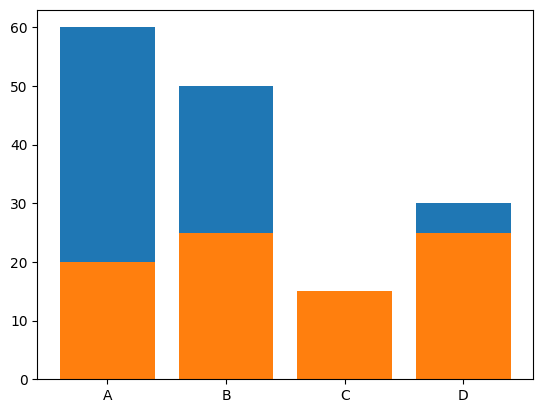

In [2]:
import matplotlib.pyplot as plt

var_1=["A","B","C","D"]
y1=[60,50,10,30]
y2=[20,25,15,25]
plt.bar(var_1,y1)
plt.bar(var_1,y2)

In [3]:
#pie charts


([<matplotlib.patches.Wedge at 0x7b3030961400>,
 [Text(0.7263848409354887, 1.4256104176313826, 'Men'),
  Text(-1.5803014104958482, 0.25029473023783994, 'Women'),
  Text(-0.20336425912892125, -1.283994929160137, 'others'),
  Text(1.2474094260779796, -0.6355861261322544, 'undifined')])

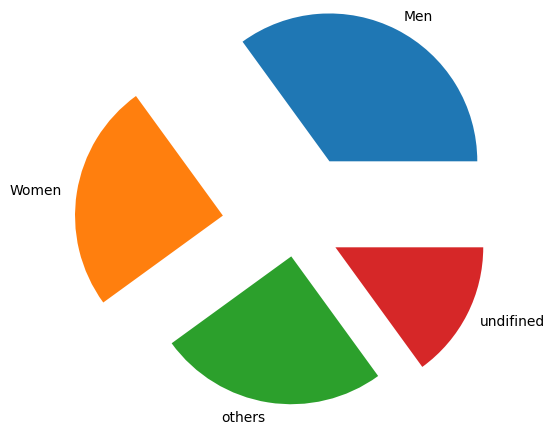

In [10]:
import numpy as np

label_1=["Men","Women","others","undifined"]

y_n=np.array([35,25,25,15])
plt.pie(y_n, labels=label_1,explode=[0.5,0.5,0.2,0.3])